### Introduction

Tuning of a rooftop PV power site by using measurement data provided by the user to find the best estimates for capacity, azimuth, and tilt for the site. 

Requires power measurements in kW, and the latitude and longitude of the site. Optionally takes a user estimate for azimuth and tilt, but these should only be filled if the user has a high level of confidence in the value(s).

If power mesurements cover both summer and winter, parameter estimates will be more accurate. Data does not have to be continuous, the example given has data for January and July only.

This example also provides accuracy analysis throughout.

### 0: Imports and functions

In [1]:
#!pip install solcast plotly kaleido

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize
from typing import Optional
import concurrent.futures

import solcast

# leave commented out to get interactive html plots
import plotly.io

plotly.io.renderers.default = "png"

In [3]:
def get_rooftop_data(
    latitude: float,
    longitude: float,
    params: dict,
    months: list,
    period: str,
    api_key: str,
) -> pd.DataFrame:
    """Runs multiple api calls for rooftop pv power with chunks of time
    as solcast.historic can only take 31 days at a time. Returns a
    concatenated df of the results"""
    futures = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as pool:
        for start, end in months:
            f = pool.submit(
                solcast.historic.rooftop_pv_power,
                latitude=latitude,
                longitude=longitude,
                **params,
                start=start,
                end=end,
                period=period,
                api_key=api_key,
            )
            futures.append(f)
    df = []
    for f in futures:
        res = f.result()
        if res.success:
            df.append(res.to_pandas())
        else:
            # NOTE for production purposes you will need to deal with API failures, e.g. due rate-limiting!
            pass

    df = pd.concat(df)
    return df


def get_season(month: pd.Index) -> str:
    """Classifies months as summer and winter used in plotting visuals"""
    if month in [10, 11, 12, 1, 2, 3]:
        return "summer"
    elif month in [4, 5, 6, 7, 8, 9]:
        return "winter"
    else:
        raise ValueError("Measurement data index cannot be categorised into months")


def generate_monthly_chunks(df_index: pd.DatetimeIndex) -> list:
    """Takes the index of the measurement data to get a start and end date for each chunk
    of time, as the solcast.historic function can only take 31 days per call. Returns
    (start,end) for each month."""
    chunks = []
    df_index = pd.to_datetime(df_index)
    unique_months = sorted(set(df_index.to_period("M")))

    for period in unique_months:
        month_start = period.start_time
        month_end = period.end_time

        # Filter the DataFrame index to get only the dates within this month
        month_data = df_index[(df_index >= month_start) & (df_index <= month_end)]

        if not month_data.empty:
            start_date = month_data.min().strftime("%Y-%m-%d")
            end_date = (month_data.max() + pd.Timedelta("24h")).strftime("%Y-%m-%d")
            chunks.append((start_date, end_date))

    return chunks


def get_solcast_untuned(
    latitude: float,
    longitude: float,
    site_parameter_estimates: dict,
    months: list,
    api_key: str,
):
    pre_tuned = get_rooftop_data(
        latitude, longitude, site_parameter_estimates, months, PERIOD, api_key
    ).tz_convert(None)
    pre_tuned.columns = ["solcast_pretuned_estimate"]
    return pre_tuned


def grid_search_parameter_estimate(
    latitude: float,
    longitude: float,
    site_parameter_estimates: dict,
    meas: pd.DataFrame,
    months: list,
    param: str,
    period: str,
    api_key: str,
    best_guess: list,
    display_results: Optional[bool] = None,
):
    """Pass in the existing metadata, measurement data and the parameter you want to estimate alongside a best guess.
    Searches for the best capacity with each parameter estimate, and optionally displays the MAE results for each parameter combo.
    First output is the best estimate for the parameter, second ouput is the estimated capacity for estimated capacity.
    """

    if display_results is None:
        display_results = False

    if not isinstance(best_guess, list):
        best_guess = [best_guess]

    allowed_parameters = ["azimuth", "tilt"]
    if not param in allowed_parameters:
        raise KeyError(
            f"Supplied parameter is not valid. Parameter must be one of the following {allowed_parameters}."
        )

    error_results = []
    param_combo = []
    site_copy = site_parameter_estimates.copy()

    for estimate in best_guess:
        site_copy[param] = estimate
        est = get_rooftop_data(
            latitude, longitude, site_copy, months, period, api_key
        ).tz_convert(None)

        # for each estimate, find the best capacity pairing.
        res = minimize(
            minimize_me,
            site_parameter_estimates["capacity"],
            args=(
                est["pv_power_rooftop"].loc[meas.index].values,
                meas[PV_POWER_COLUMN].values,
            ),
        )
        capacity_est = np.round(res.x[0] * site_parameter_estimates["capacity"], 0)
        error = res.fun
        param_combo.append((estimate, capacity_est))
        error_results.append({"capacity": capacity_est, "mae%": 100 * error})
    results_df = pd.DataFrame.from_records(error_results, index=best_guess)
    results_df.index.name = param
    results_df = results_df.sort_values(by="mae%")
    if display_results:
        display(results_df.round(1))

    # take the lowest error result from the capacity and parameter pairing
    est_param = results_df["mae%"].idxmin()
    est_capacity = results_df.loc[est_param, "capacity"]

    return est_param, est_capacity


def calculate_stats(
    meas: pd.DataFrame,
    est: pd.DataFrame,
    df: bool,
):
    """Calculates the accuracy statistics for given measurements and data.
    If df is True, returns a dataframe."""

    meas = meas.squeeze().dropna()
    meas = meas.reindex(est.index)
    est = est.squeeze()
    obs_mean = meas.mean()
    diff = est - meas

    stats = {
        "obs_mean": obs_mean,
        "est_mean": est.mean(),
        "bias%": diff.mean() / obs_mean * 100,
        "mae%": diff.abs().mean() / obs_mean * 100,
        "rmse%": np.sqrt(np.mean(diff**2)) / obs_mean * 100,
        "r": pd.concat([est, meas], axis=1).corr().iloc[0].iloc[1],
        "stddev": np.sqrt(np.mean(np.square(diff - np.mean(diff)))),
    }

    if df:
        stats = pd.DataFrame.from_records([stats]).round(2)
    return stats


def display_evaluation_plots(
    meas: pd.DataFrame, est: pd.DataFrame, untuned: Optional[pd.DataFrame] = None
):

    meas = meas.drop("season", axis=1)
    meas = meas.reindex(est.index)
    est = est.squeeze()
    meas = meas.squeeze()
    if not (untuned is None):
        untuned = untuned.squeeze()

    # Plot 1: Timeseries
    combined_df = pd.concat((meas, est), axis=1)
    combined_df.columns = ["meas", "solcast estimate"]
    if not (untuned is None):
        combined_df["untuned"] = untuned

    combined_df["season"] = combined_df.index.month.map(get_season)
    timeseries_fig = px.line(
        combined_df,
        title="Measurement vs Estimate Timeseries",
        facet_row="season",
        height=1000,
        width=1200,
    )
    timeseries_fig.update_xaxes(matches=None)
    timeseries_fig.update_yaxes(title_text="kW")
    timeseries_fig.update_layout(xaxis2=dict(showticklabels=True))

    # Plot 2: X-Y Plot
    xy_fig = go.Figure(layout=dict(height=700, width=700))

    # add measurement vs estimate data
    xy_fig.add_trace(
        go.Scatter(
            x=meas,
            y=est,
            name="Estimate",
            mode="markers",
            marker=dict(color="red"),
        )
    )
    if not (untuned is None):
        # add measurement vs untuned estimate data
        xy_fig.add_trace(
            go.Scatter(
                x=meas,
                y=untuned,
                name="Untuned",
                mode="markers",
                marker=dict(color="blue"),
            )
        )

    # add x-y line
    xy_fig.add_shape(
        type="line",
        x0=0,
        y0=0,
        x1=np.max([meas.max(), est.max()]),
        y1=np.max([meas.max(), est.max()]),
        line=dict(color="black", width=1.5),
    )

    xy_fig.update_xaxes(title_text="Measured Generation (kW)")
    xy_fig.update_yaxes(title_text="Estimate (kW)")

    # Table 1: Statistics
    stats_table = calculate_stats(meas, est, df=True)

    if not (untuned is None):
        stats_table_untuned = calculate_stats(meas, untuned, df=True)

    display(timeseries_fig)
    display(xy_fig)
    if not (untuned is None):
        print("Untuned Statistics")
        display(stats_table_untuned)
    print("Estimated Statistics")
    display(stats_table)

    return


def minimize_me(x, est, obs):
    """Calculates the MAE for given scenario to be used in scipy.optimize.minimize() for grid_search_parameter_estimate()"""
    error = np.mean(np.abs(est * x[0] - obs))
    return error

## 1a: Input user Data

Replace the variables in the following cell with your own values

In [4]:
API_KEY = os.environ["API_KEY"]
measurement_data = pd.read_csv(
    "https://solcast.github.io/solcast-api-python-sdk/notebooks/data/3.4_sample_measurements.csv",
    index_col=[0],
    parse_dates=True,
)  # Make sure this is in kW
PV_POWER_COLUMN = (
    "pv_power_rooftop"  # Set this to the name of the power column in measurement_data
)
LONGITUDE = 151.215297
LATITUDE = -33.856784
PERIOD = "PT60M"

# Set this to true if User data is in local timezone and not UTC
LOCAL_TIMEZONE = False

# Optional inputs. Only supply these if you have a high level of confidence they are close to the true value.
USER_INPUT_AZI = None
USER_INPUT_TILT = None

# Save output to csv?
SAVE_TO_CSV = False

### 1b: Visualise User Data with a Pre-tuned Estimate

In [5]:
# setup estimates
site_parameter_estimates = {}
if USER_INPUT_AZI is not None:
    site_parameter_estimates["azimuth"] = USER_INPUT_AZI
if USER_INPUT_TILT is not None:
    site_parameter_estimates["tilt"] = USER_INPUT_TILT

In [6]:
# align to UTC if required
utc_offset = LONGITUDE // 15
utc_offset = pd.Timedelta(f"{utc_offset}h")
if LOCAL_TIMEZONE:
    measurement_data.index = measurement_data.index - utc_offset
print(
    "We estimate your UTC offset is ", utc_offset, ". You can update this if incorrect."
)

We estimate your UTC offset is  0 days 10:00:00 . You can update this if incorrect.


In [7]:
# separate data into seasons
measurement_data["season"] = measurement_data.index.month.map(get_season)
number_of_seasons = measurement_data["season"].nunique()
months = generate_monthly_chunks(measurement_data.index)

In [8]:
# required for all grid searches
KWARGS = {
    "latitude": LATITUDE,
    "longitude": LONGITUDE,
    "meas": measurement_data,
    "months": months,
    "site_parameter_estimates": site_parameter_estimates,
    "period": PERIOD,
    "api_key": API_KEY,
}

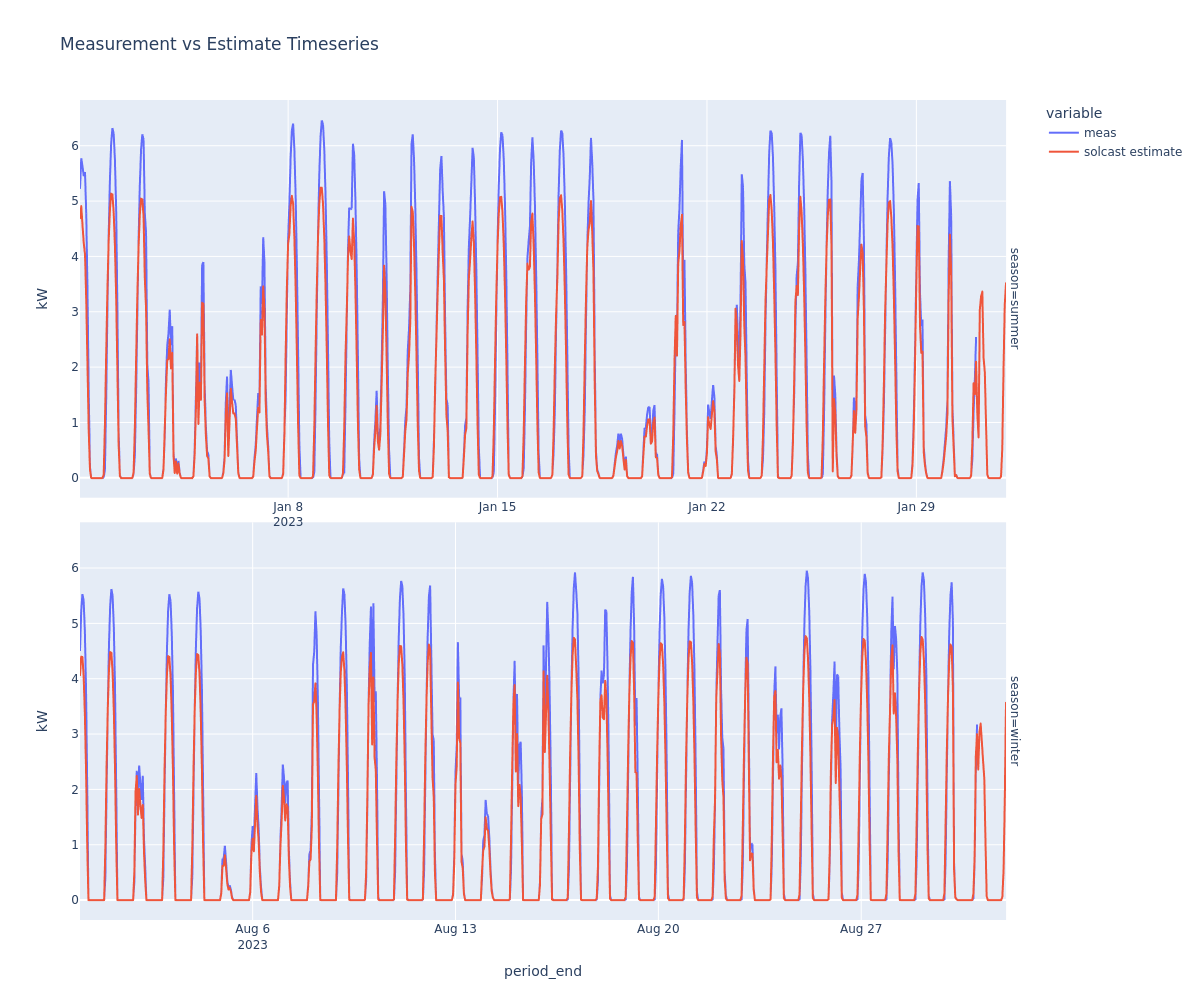

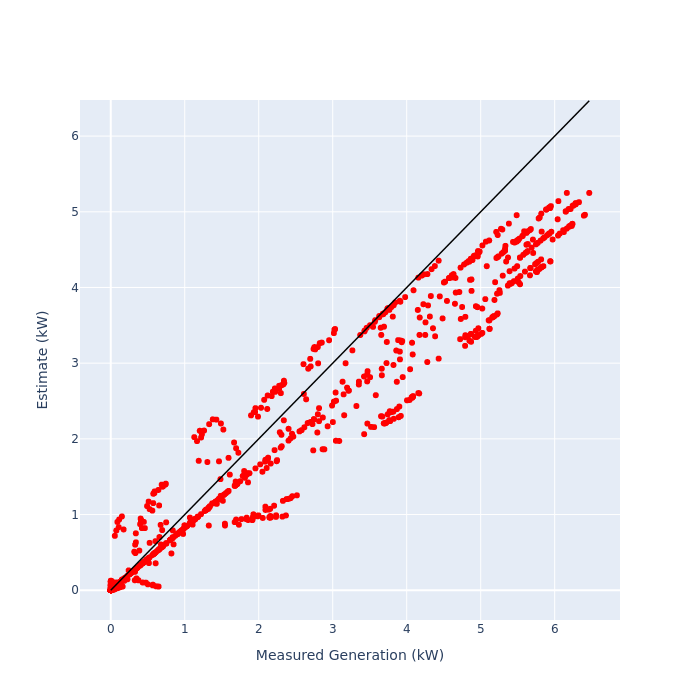

Estimated Statistics


,obs_mean,est_mean,bias%,mae%,rmse%,r,stddev
0,1.37,1.13,-17.44,22.14,40.83,0.98,0.51


In [9]:
# take an initial capacity estimate and show an initial estimation with no tuning
capacity_initial_estimate = measurement_data[PV_POWER_COLUMN].max()
site_parameter_estimates["capacity"] = capacity_initial_estimate

pre_tuned = get_solcast_untuned(
    LATITUDE, LONGITUDE, site_parameter_estimates, months, API_KEY
)
display_evaluation_plots(measurement_data, pre_tuned)

### 2a: Finding an Azimuth Estimate

Runs a grid search for a wide range of values of azimuth and finds the best capacity pairing. 

Then runs again around the pair with the lowest error and does a narrower search.

In [10]:
if USER_INPUT_AZI is None:
    # Use these defaults or update the range if you prefer
    initial_azi_min = -180
    initial_azi_max = 180
    azi_delta = 45
else:
    azi_delta = 45
    initial_azi_min = USER_INPUT_AZI - azi_delta
    initial_azi_max = USER_INPUT_AZI + azi_delta

# Initial wide search
initial_azimuth_search = np.arange(
    initial_azi_min, initial_azi_max + 1, azi_delta
).tolist()
first_guess_azi, updated_capacity_est = grid_search_parameter_estimate(
    **KWARGS, param="azimuth", best_guess=initial_azimuth_search, display_results=False
)

# Secondary search around estimate from wide search
secondary_azimuth_search = np.arange(
    int(first_guess_azi - azi_delta / 2), int(first_guess_azi + azi_delta / 2), 2
).tolist()
azi_est, updated_capacity_est = grid_search_parameter_estimate(
    **KWARGS, param="azimuth", best_guess=secondary_azimuth_search, display_results=True
)

print(f"Best guess for azimuth: {azi_est}")
print(f"Best guess for capacity: {updated_capacity_est}")

,capacity,mae%
azimuth,,
32,8.0,3.8
30,8.0,4.0
34,8.0,4.0
36,8.0,4.4
28,8.0,4.6
38,8.0,4.8
40,8.0,5.3
26,8.0,5.4
42,8.0,5.9


Best guess for azimuth: 32
Best guess for capacity: 8.0


### 2b: Update with the Results

In [11]:
site_parameter_estimates["capacity"] = updated_capacity_est
site_parameter_estimates["azimuth"] = azi_est
print("Current Parameter Updates:", site_parameter_estimates)

Current Parameter Updates: {'capacity': 8.0, 'azimuth': 32}


### 3a: Finding a Tilt Estimate

Runs a grid search for a wide range of values of tilt and finds the best capacity pairing. 

Then runs again around the pair with the lowest error and does a narrower search.

In [12]:
if USER_INPUT_TILT is None:
    # Use these defaults or update the range if you prefer
    initial_tilt_min = 0
    initial_tilt_max = 90
    tilt_delta = 10
else:
    tilt_delta = 10
    initial_tilt_min = USER_INPUT_TILT - tilt_delta
    initial_tilt_max = USER_INPUT_TILT + tilt_delta


# Initial wide search
initial_tilt_search = np.arange(
    initial_tilt_min, initial_tilt_max + 1, tilt_delta
).tolist()
first_guess_tilt, updated_capacity_est = grid_search_parameter_estimate(
    **KWARGS, param="tilt", best_guess=initial_tilt_search, display_results=False
)

# Secondary search around estimate from wide search
secondary_tilt_search = np.arange(
    first_guess_tilt - tilt_delta / 2, first_guess_tilt + tilt_delta / 2, 1
).tolist()
tilt_est, updated_capacity_est = grid_search_parameter_estimate(
    **KWARGS, param="tilt", best_guess=secondary_tilt_search, display_results=True
)

print(f"Best guess for tilt: {tilt_est}")
print(f"Best guess for capacity: {updated_capacity_est}")

,capacity,mae%
tilt,,
27.0,8.0,1.1
28.0,8.0,1.2
26.0,8.0,1.7
29.0,8.0,1.8
25.0,8.0,2.4
30.0,8.0,2.5
31.0,8.0,3.3
32.0,8.0,4.0
33.0,8.0,4.8


Best guess for tilt: 27.0
Best guess for capacity: 8.0


### 3b: Update with the Results

In [13]:
site_parameter_estimates["capacity"] = updated_capacity_est
site_parameter_estimates["tilt"] = tilt_est
print("Current Parameter Updates:", site_parameter_estimates)

Current Parameter Updates: {'capacity': 8.0, 'azimuth': 32, 'tilt': 27.0}


### 4: Final Result

Takes the calculated best estimates for azimuth, tilt and capacity to find a tuned estimate for your rooftop pv power site. 

Performs accuracy analysis on the final result

Tuned Parameter Estimates: {'capacity': 8.0, 'azimuth': 32, 'tilt': 27.0}


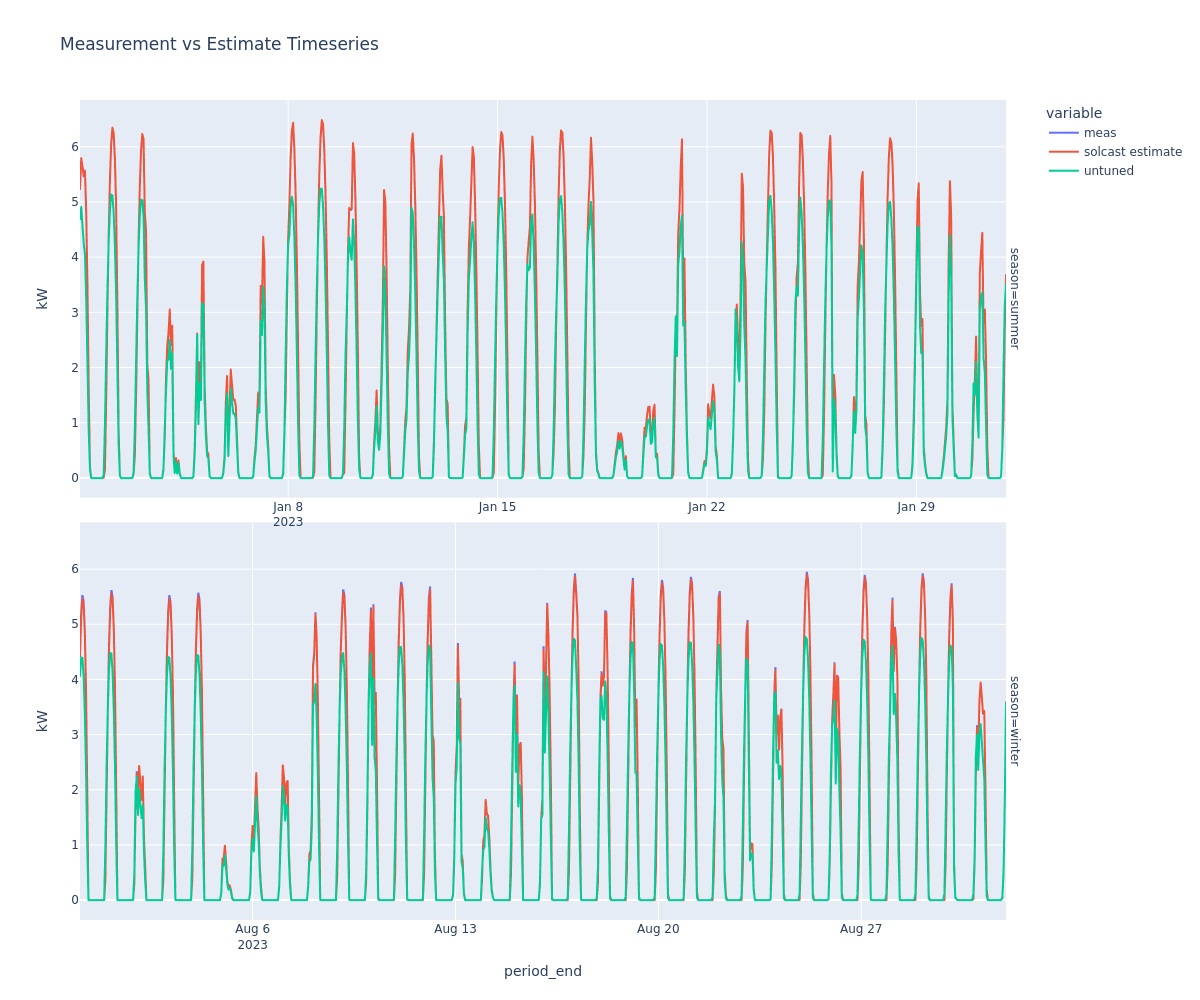

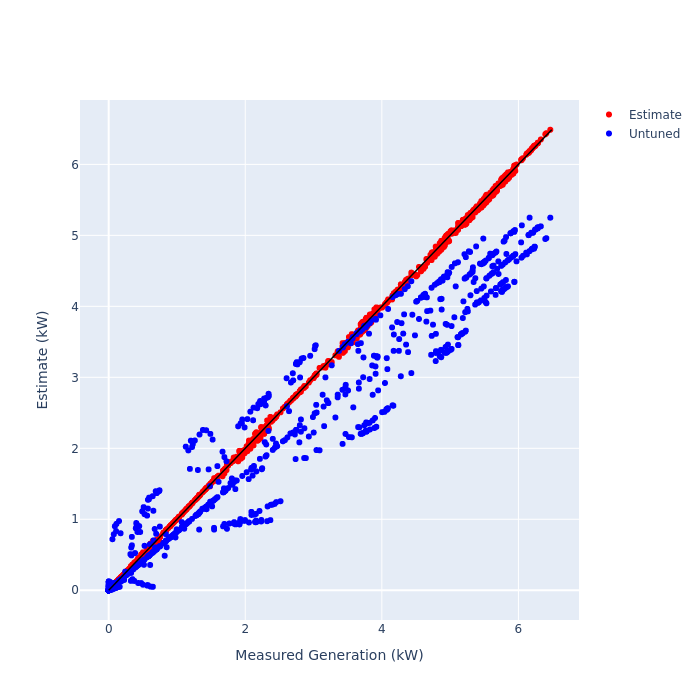

Untuned Statistics


,obs_mean,est_mean,bias%,mae%,rmse%,r,stddev
0,1.37,1.13,-17.44,22.14,40.83,0.98,0.51


Estimated Statistics


,obs_mean,est_mean,bias%,mae%,rmse%,r,stddev
0,1.37,1.36,-0.23,0.83,1.7,1.0,0.02


In [14]:
est_final = get_rooftop_data(
    LATITUDE, LONGITUDE, site_parameter_estimates, months, PERIOD, API_KEY
).tz_convert(None)["pv_power_rooftop"]

est_df = pd.DataFrame(
    data={
        "meas": measurement_data[PV_POWER_COLUMN],
        "solcast_estimate": est_final,
        "solcast_pre_tuned": pre_tuned["solcast_pretuned_estimate"],
    },
    index=measurement_data.index,
)
if SAVE_TO_CSV:
    est_df.to_csv("Solcast_Tuned_Rooftop_PV.csv")

print("Tuned Parameter Estimates:", site_parameter_estimates)

results = calculate_stats(measurement_data[PV_POWER_COLUMN], est_final, df=True)
display_evaluation_plots(meas=measurement_data, est=est_final, untuned=pre_tuned)